In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

plt.rcParams['figure.figsize'] = 18, 9 #FIGURE!!!

Browse catalogue to find IWP data and surface temperature too

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hfls,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,6hrPlev,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,clt,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,evspsbl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
df_iwp = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'clivi' & experiment_id == '1pctCO2'")

df_ts = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")

In [ ]:
df_iwp.source_id #check what models we have

## Load Data

Now we will load a single store using gcsfs, zarr, and xarray.
Global average IWP as a deviation from the average of the first 20 years
=> this first script assumes all ensemble members!

areacella = area of each of the grid cells, needed for computing global averages

3
(1800,)
IPSL-CM6A-LR
CPU times: user 1.94 s, sys: 706 ms, total: 2.65 s
Wall time: 8.61 s
4
(1812,)
GISS-E2-1-G
CPU times: user 996 ms, sys: 376 ms, total: 1.37 s
Wall time: 3.62 s
5
(1800,)
CNRM-ESM2-1
CPU times: user 3.03 s, sys: 1.08 s, total: 4.11 s
Wall time: 11.8 s
6
(1800,)
CNRM-ESM2-1
CPU times: user 2.99 s, sys: 1.05 s, total: 4.03 s
Wall time: 13.6 s
7
(1800,)
CNRM-ESM2-1
CPU times: user 2.06 s, sys: 840 ms, total: 2.9 s
Wall time: 9.58 s
8
(1812,)
MRI-ESM2-0
CPU times: user 4.83 s, sys: 1.51 s, total: 6.35 s
Wall time: 18.9 s


Text(0.5, 1.0, 'Global Mean ice water path in 1 pct CO2 experiment')

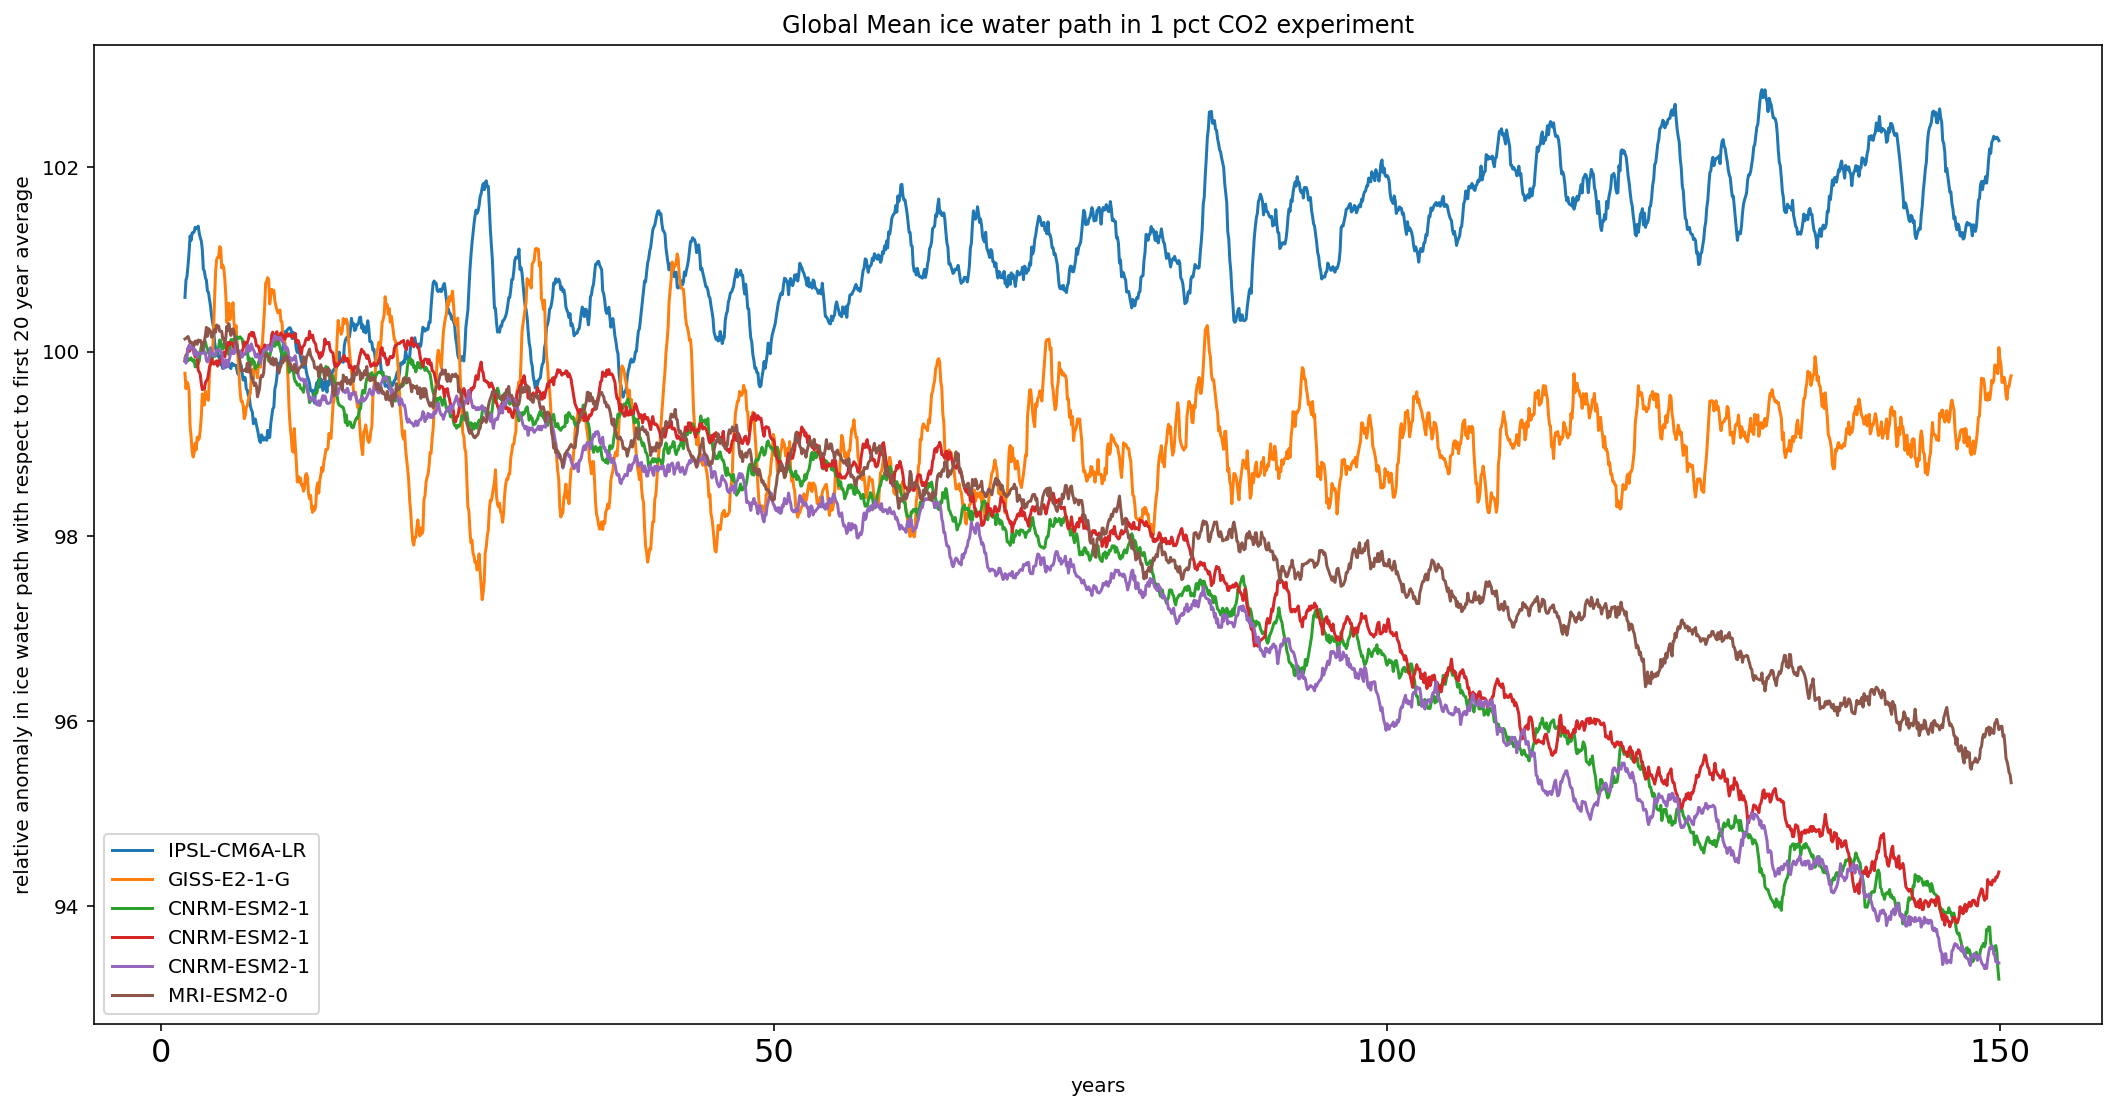

In [4]:
# this only needs to be created once
from matplotlib import pyplot as plt
gcs = gcsfs.GCSFileSystem(token='anon')

b=[]
allid=[]
allind = np.arange(0,len(df_iwp))
exclude=np.array([2,9,32,46,47,52,53,55,56,57,64,70,71,72,75,76,77,79])
#I excluded many of the models, because they had problems with the "areacella" variable
allind2= np.delete(allind, exclude)

inds=np.arange(3,9) #here just for testing purposes, plotting only models 3 - 9
#for i in range(10,len(df_iwp)):
for i in np.nditer(inds):
    print(i)
    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = df_iwp.zstore.values[i]

    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    
    #make global average
    model_id = ds.source_id
    allid.append(model_id)
    
    df_area = df.query("variable_id == 'areacella' & source_id == @model_id")
    ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
    #ds_area
    
    total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
    iwp_timeseries = (ds.clivi * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
    print(iwp_timeseries.shape)
    print(model_id)
    %time iwp_timeseries.load()
    #print(np.max(iwp_timeseries))

    #plot the rolling mean over 24 months
    rmean=iwp_timeseries.rolling(time=24).mean()
    #"append" the data, so that we can use that "b" in plotting of the legend
    b.append(plt.plot(rmean*100/np.nanmean(rmean[0:120]))[0])
plt.legend(b,allid)

plt.xticks([0,600,1200,1800],('0','50','100','150'),fontsize=16)
plt.ylabel('relative anomaly in ice water path with respect to first 20 year average')
plt.xlabel('years')
plt.title('Global Mean ice water path in 1 pct CO2 experiment')

MAKE THE SAME BUT IN FUNCTION OF TEMPERATURE (IWP anomaly on Y axis, TEMP anomaly on X axis)
iwp = ice water path
twp = total water path (ice + liquid)
ts  = surface temperature

Note that I am here plotting values between 15 deg S and 15 deg N only!

In [7]:
df_iwp = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'clivi' & experiment_id == '1pctCO2' & member_id =='r1i1p1f1'")
df_twp = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'clwvi' & experiment_id == '1pctCO2' & member_id =='r1i1p1f1'")
df_ts = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id =='r1i1p1f1'")

In [8]:
len(df_iwp.source_id)

42

0 GFDL-CM4 model
GFDL-CM4
GFDL-CM4
CPU times: user 4.43 s, sys: 1.66 s, total: 6.09 s
Wall time: 18.5 s
CPU times: user 4.13 s, sys: 1.36 s, total: 5.49 s
Wall time: 22.9 s
1 GFDL-ESM4 model
GFDL-ESM4
GFDL-ESM4
CPU times: user 4.78 s, sys: 1.62 s, total: 6.4 s
Wall time: 20 s
CPU times: user 4.15 s, sys: 1.39 s, total: 5.54 s
Wall time: 17.3 s
2 IPSL-CM6A-LR model
IPSL-CM6A-LR
IPSL-CM6A-LR
CPU times: user 3.36 s, sys: 833 ms, total: 4.19 s
Wall time: 18.5 s
CPU times: user 1.56 s, sys: 503 ms, total: 2.06 s
Wall time: 8.66 s
3 GISS-E2-1-G model
GISS-E2-1-G
GISS-E2-1-G
CPU times: user 1.38 s, sys: 411 ms, total: 1.79 s
Wall time: 6.14 s
CPU times: user 914 ms, sys: 251 ms, total: 1.16 s
Wall time: 4.17 s
4 MRI-ESM2-0 model
MRI-ESM2-0
MRI-ESM2-0
CPU times: user 4.84 s, sys: 1.34 s, total: 6.18 s
Wall time: 18.2 s
CPU times: user 4.14 s, sys: 1.18 s, total: 5.32 s
Wall time: 13.8 s
5 BCC-CSM2-MR model
BCC-CSM2-MR
BCC-CSM2-MR
CPU times: user 5.25 s, sys: 1.41 s, total: 6.66 s
Wall time: 16

/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


MIROC6
MIROC6
CPU times: user 2.46 s, sys: 835 ms, total: 3.3 s
Wall time: 11.5 s
CPU times: user 2.56 s, sys: 779 ms, total: 3.34 s
Wall time: 8.02 s
7 SAM0-UNICON model
SAM0-UNICON
SAM0-UNICON
CPU times: user 5.04 s, sys: 1.47 s, total: 6.51 s
Wall time: 18.6 s
CPU times: user 3.6 s, sys: 1.17 s, total: 4.77 s
Wall time: 14 s
8 GISS-E2-1-H model
GISS-E2-1-H
GISS-E2-1-H
CPU times: user 1.28 s, sys: 379 ms, total: 1.66 s
Wall time: 4.24 s
CPU times: user 1.02 s, sys: 290 ms, total: 1.31 s
Wall time: 4 s
9 CESM2 model
CESM2
CESM2
CPU times: user 4.58 s, sys: 1.44 s, total: 6.02 s
Wall time: 17.9 s
CPU times: user 4.13 s, sys: 1.31 s, total: 5.45 s
Wall time: 12.8 s
10 CESM2-WACCM model
CESM2-WACCM
CESM2-WACCM
CPU times: user 5.2 s, sys: 1.41 s, total: 6.61 s
Wall time: 16.2 s
CPU times: user 4.15 s, sys: 1.31 s, total: 5.46 s
Wall time: 13.3 s
11 CanESM5 model
CanESM5
CanESM5
CPU times: user 677 ms, sys: 216 ms, total: 893 ms
Wall time: 3.63 s
CPU times: user 360 ms, sys: 139 ms, total:

/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.da

ACCESS-CM2
ACCESS-CM2
CPU times: user 2.08 s, sys: 693 ms, total: 2.77 s
Wall time: 9.64 s
CPU times: user 2 s, sys: 599 ms, total: 2.6 s
Wall time: 5.99 s
25 ACCESS-ESM1-5 model


/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/Users/Blaz/opt/anaconda3/envs/blaz_env/lib/python3.8/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.da

ACCESS-ESM1-5
ACCESS-ESM1-5
CPU times: user 1.91 s, sys: 672 ms, total: 2.58 s
Wall time: 10.6 s
CPU times: user 2 s, sys: 619 ms, total: 2.61 s
Wall time: 6.43 s
26 GISS-E2-2-G model
GISS-E2-2-G
GISS-E2-2-G
CPU times: user 1.15 s, sys: 335 ms, total: 1.48 s
Wall time: 4.47 s
CPU times: user 876 ms, sys: 230 ms, total: 1.11 s
Wall time: 3.37 s
27 IITM-ESM model
IITM-ESM
IITM-ESM
CPU times: user 1.56 s, sys: 431 ms, total: 1.99 s
Wall time: 5.46 s
CPU times: user 1.21 s, sys: 370 ms, total: 1.58 s
Wall time: 4.18 s
28 FGOALS-g3 model
FGOALS-g3
FGOALS-g3
CPU times: user 1.46 s, sys: 374 ms, total: 1.84 s
Wall time: 4.58 s
CPU times: user 972 ms, sys: 267 ms, total: 1.24 s
Wall time: 4.21 s
29 TaiESM1 model
TaiESM1
TaiESM1
CPU times: user 3.96 s, sys: 1.29 s, total: 5.25 s
Wall time: 19.3 s
CPU times: user 3.37 s, sys: 1.1 s, total: 4.47 s
Wall time: 14.4 s
30 INM-CM5-0 model
INM-CM5-0
INM-CM5-0
CPU times: user 1.49 s, sys: 492 ms, total: 1.98 s
Wall time: 7.21 s
CPU times: user 1.67 s, s

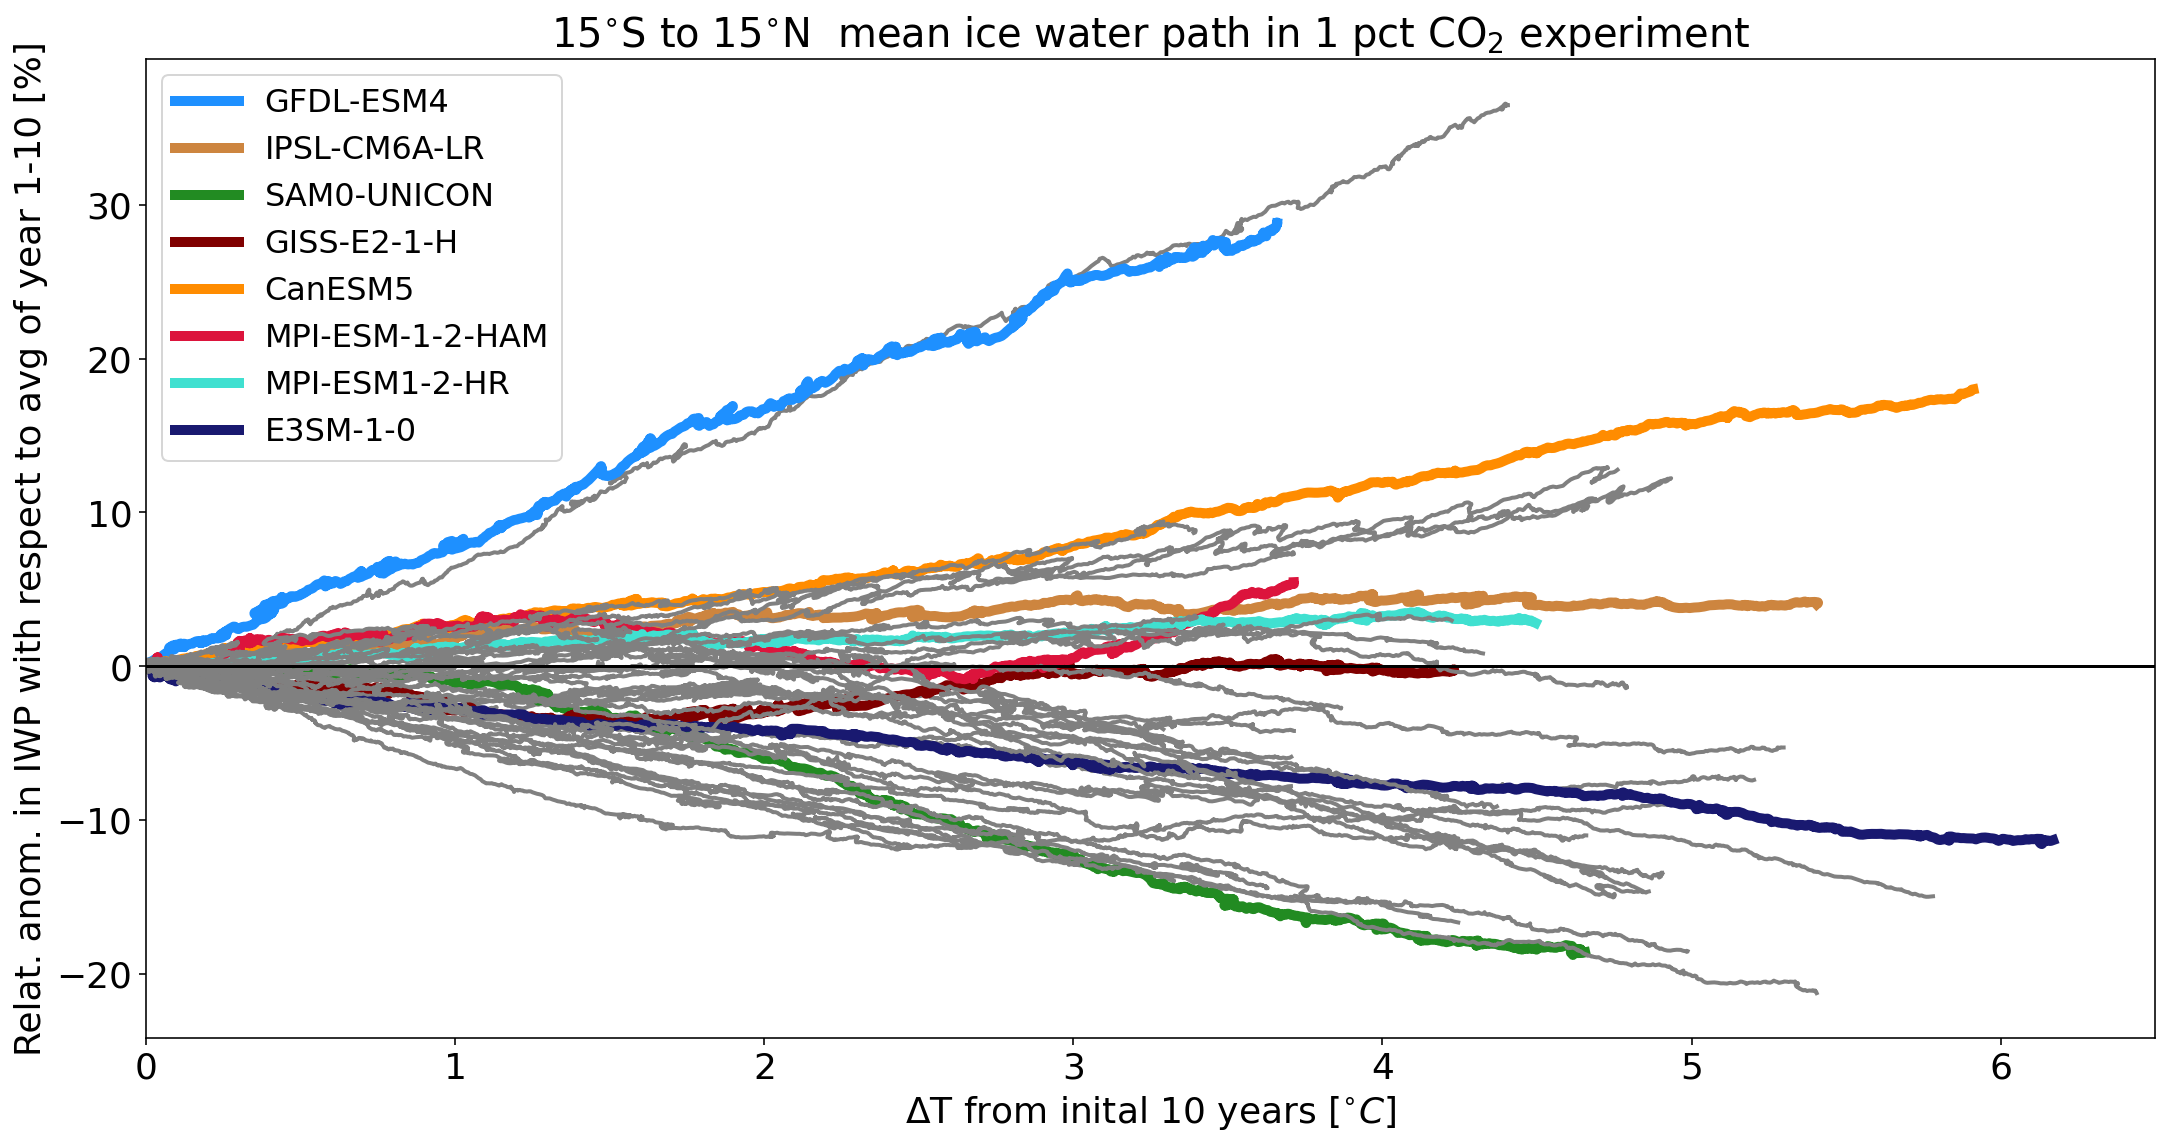

In [9]:
#TEST
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
gcs = gcsfs.GCSFileSystem(token='anon')

b=[]
allid=[]
boldid=[]
inds=np.arange(0,2) #!!!FULL RANGE max =41

#for i in np.nditer(inds):
#for i in range(0,len(df_iwp.source_id)):
for i,mod in enumerate(df_iwp.source_id[:]):
    print(i,mod,'model')
    #i = i +39
    
    df_ts1 = df.query("activity_id=='CMIP' & table_id == 'Amon' & source_id ==@mod & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id =='r1i1p1f1'")
    
    zstore = df_iwp.zstore.values[i]
    zstore2= df_ts1.zstore.values[0]
    
    # create a mutable-mapping-style interface to the store
    mapper = gcs.get_mapper(zstore)
    mapper2 = gcs.get_mapper(zstore2)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    ds2 = xr.open_zarr(mapper2, consolidated=True)
    
    #make global average
    model_id = ds.source_id
    model_id2 = ds2.source_id
    allid.append(model_id)
    
    iwp = ds.clivi
    ts = ds2.tas
    #select the latitude
    latind = np.where(((iwp['lat']>=-15) & (iwp['lat']<=15)))[0]
    latind2 = np.where(((ts['lat']>=-15) & (ts['lat']<=15)))[0]
    iwp_20to20  =  iwp[:,latind,:]
    #Beware! I am not using weighted means. This is acceptable for the tropics, but not for global means etc.!!!
    iwp_20to20_mean = iwp_20to20.mean(dim=['lon','lat'])
    
    ts_20to20  =  ts[:,latind2,:]
    ts_20to20_mean = ts_20to20.mean(dim=['lon','lat'])
    
    print(model_id)
    print(model_id2)
    %time iwp_20to20_mean.load()
    %time ts_20to20_mean.load() #the time in front   Aiko used %timeit -n 1 -r 1


    rmean=iwp_20to20_mean.rolling(time=120).mean()
    rmean_ts=ts_20to20_mean.rolling(time=120).mean()
    
    #the following 2 lines are used sometimes for debugging purposes 
    #print(rmean.shape, 'iwp shape')
    #print(rmean_ts.shape,' ts shape')
    
    if i==40:
        rmean_ts=rmean_ts[0:len(rmean)]
        
    
    #I want to highlight some of the models, wiht the number 1,2,7... as per "boldies" array
    boldies = [1,2,7,8,11,14,17,19]
    width = np.full((41), 2)
    width[boldies]= 5
    colors=['dodgerblue','peru','forestgreen','maroon','darkorange','crimson','turquoise','midnightblue']

    plt.plot(rmean_ts - np.nanmean(rmean_ts[0:120]),-100+rmean*100/np.nanmean(rmean[0:120]),linewidth=2,color='gray')
    if i==1:
        j=-1 #just a trick to get the index right...
    if (i == 1) | (i==2) | (i==7) | (i==8) | (i==11) | (i==14) | (i==17) | (i==19):
        j=j+1
        boldid.append(model_id)
        b.append(plt.plot(rmean_ts - np.nanmean(rmean_ts[0:120]),-100+rmean*100/np.nanmean(rmean[0:120]),linewidth=5,color=colors[j])[0])

    
plt.axhline(0, color='black')
plt.legend(b,boldid,fontsize=16)
plt.xlim(0,6.5)
plt.ylabel('Relat. anom. in IWP with respect to avg of year 1-10 [%]',fontsize=18)
plt.xlabel('$\Delta$T from inital 10 years [$^{\circ}C$]',fontsize=18)
plt.title('15$^{\circ}$S to 15$^{\circ}$N  mean ice water path in 1 pct CO$_2$ experiment',fontsize=20)
#plt.savefig('/Users/Blaz/Documents/wien_021/CMIP/plots/IWP_vs_Tsurf_1pctCO2_selected_models.pdf',dpi=200,bbox_inches='tight')